# SETTING UP

### Import libraries

In [31]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler #to scale data 
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


### Set seed for reproducibility

In [32]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [33]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Importing data

In [34]:
dataset_dir = '/kaggle/input/training-datasethomework2/training_dataset_homework2'

In [35]:
X_train = np.load(os.path.join(dataset_dir,'x_train.npy'))
Y_train = np.load(os.path.join(dataset_dir,'y_train.npy'))

In [36]:
classes_dict = {0: "Wish",
          1: "Another",
          2: "Comfortably",
          3: "Money",
          4: "Breathe",
          5: "Time",
          6: "Brain",
          7: "Echoes",
          8: "Wearing",
          9: "Sorrow",
          10: "Hey", 
          11: "Shine"
          }

classes_dict.values()

classes_labels = list(classes_dict.values())

Y_train_labels=[]

for i in Y_train:
    Y_train_labels.append(classes_labels[Y_train[i]])

In [37]:
feat_dict = {0: 'FEAT_1',
               1: 'FEAT_2',
               2: 'FEAT_3',
               3: 'FEAT_4',
               4: 'FEAT_5',
               5: 'FEAT_6'}

feat_labels = list(feat_dict.values())

### Utilities to inspect data

In [38]:
#to check the result of different preprocessing routines

from matplotlib.lines import Line2D


def inspect_multivariate(X, Y, columns,ts_labels, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    print('The class of this time series is ' + ts_labels[np.argmax(Y[idx,:])])
        
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,30))
    for i, col in enumerate(columns):
        #np.arange(len(X[0,:,i])) --> returns an array of numbers from 1 to 36
        #X[idx,:,i] --> returns the curve with respect to feature i of a time series samplem from random index idx
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i],marker=Line2D.filled_markers[0])
        axs[i].set_title(col)
    
    plt.show()

### Splitting data

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.2, 
                                                  random_state = seed,
                                                  stratify = Y_train)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print('Shapes:')
print('x_train: ', x_train.shape)
print('x_val: ', x_val.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)

Shapes:
x_train:  (1943, 36, 6)
x_val:  (486, 36, 6)
y_train:  (1943, 12)
y_val:  (486, 12)


### Preprocess

In [40]:
#scaling along features
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
scaler = RobustScaler() #could be replaced

x_train_new = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_val_new = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)

print('Output shape:')
x_train_new.shape, x_val_new.shape

Output shape:


((1943, 36, 6), (486, 36, 6))

In [41]:
x_train = x_train_new
x_val = x_val_new

# DEALING WITH CLASS IMBALANCE

### Oversampling
docs: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler

Training:
Counter({9: 622, 3: 305, 6: 250, 2: 216, 5: 122, 1: 98, 8: 96, 10: 62, 7: 54, 4: 50, 11: 41, 0: 27})
Validation:
Counter({9: 155, 3: 76, 6: 63, 2: 54, 5: 31, 1: 25, 8: 24, 10: 15, 7: 14, 4: 12, 11: 10, 0: 7})


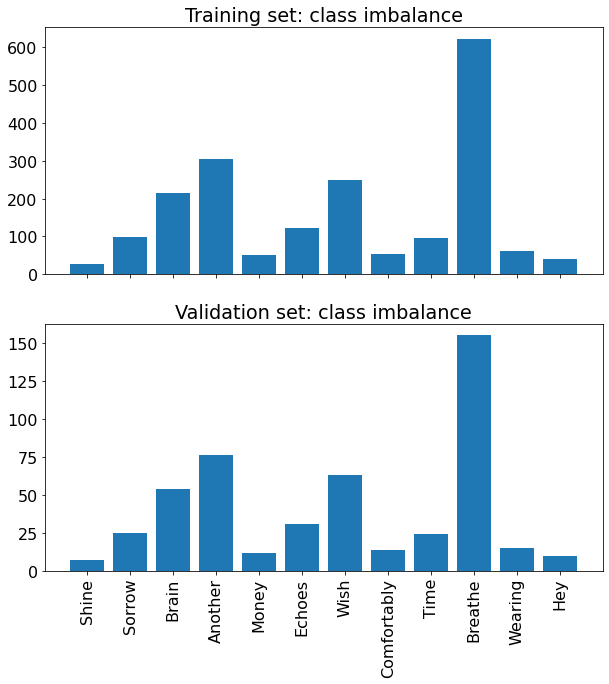

In [42]:
#class imbalance in train and validation
import collections

train_counter = collections.Counter(np.argmax(y_train,axis=-1))   
print("Training:")
print(train_counter)
val_counter = collections.Counter(np.argmax(y_val,axis=-1)) 
print("Validation:")
print(val_counter)

figs, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))

#training set
axs[0].bar(train_counter.keys(), train_counter.values(),tick_label=classes_labels)
axs[0].set_title('Training set: class imbalance')

#validation set
axs[1].bar(val_counter.keys(), val_counter.values(),tick_label=classes_labels)
axs[1].set_title('Validation set: class imbalance')

plt.xticks(rotation=90)
plt.show()

In [43]:
!pip install -U imbalanced-learn

In [44]:
#oversampling
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=seed)

x_train_new = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

x_train_new, y_train_new = over_sampler.fit_resample(x_train_new, y_train)

x_train_new = np.reshape(x_train_new, (x_train_new.shape[0],x_train.shape[1],x_train.shape[2]))
x_train_new.shape

(7464, 36, 6)

Training:
Counter({3: 622, 9: 622, 6: 622, 10: 622, 1: 622, 5: 622, 2: 622, 7: 622, 8: 622, 4: 622, 0: 622, 11: 622})
Validation:
Counter({9: 155, 3: 76, 6: 63, 2: 54, 5: 31, 1: 25, 8: 24, 10: 15, 7: 14, 4: 12, 11: 10, 0: 7})


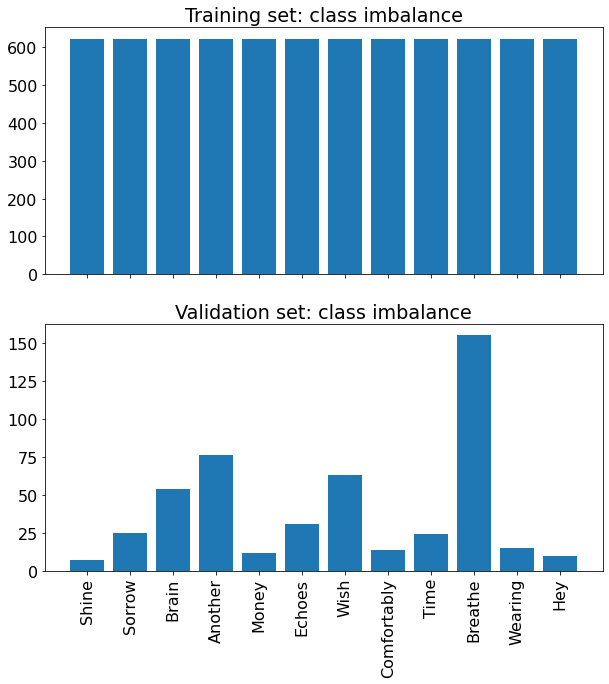

In [45]:
#class imbalance in train and validation
import collections

train_counter = collections.Counter(np.argmax(y_train_new,axis=-1))   
print("Training:")
print(train_counter)
val_counter = collections.Counter(np.argmax(y_val,axis=-1)) 
print("Validation:")
print(val_counter)

figs, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))

#training set
axs[0].bar(train_counter.keys(), train_counter.values(),tick_label=classes_labels)
axs[0].set_title('Training set: class imbalance')

#validation set
axs[1].bar(val_counter.keys(), val_counter.values(),tick_label=classes_labels)
axs[1].set_title('Validation set: class imbalance')

plt.xticks(rotation=90)
plt.show()

### Weighting

In [46]:
from sklearn.utils import class_weight
 
class_weights = class_weight.compute_class_weight(
                'balanced',
                classes = np.unique(Y_train), 
                y = Y_train)

class_weights = dict(enumerate(class_weights))  

# DATA AUGMENTATION
tsaug docs: https://github.com/arundo/tsaug

In [47]:
!pip install tsaug

In [48]:
#sample a random fraction of data
np.random.seed(seed)

def random_sample(X,Y, rate):
    indexes = np.random.choice(X.shape[0], size=int(np.floor(rate*X.shape[0])), replace=False)
    return X[indexes,:,:], Y[indexes,:]

y_train_int = np.argmax(y_train,axis=-1)
x_sampled, y_sampled = random_sample(x_train[y_train_int!=9,:,:], y_train[y_train_int!=9,:], 0.3)

print('Sampled shapes:')
print(x_sampled.shape)
print(y_sampled.shape)

Sampled shapes:
(396, 36, 6)
(396, 12)


In [49]:
#feeding the correct shape to the augmenter
y_sampled_new = np.reshape(y_sampled, newshape = (y_sampled.shape[0],1,12))
y_sampled_new = np.repeat(y_sampled_new,36,axis=1)

y_sampled_new = np.argmax(y_sampled_new,axis=-1)

y_sampled_new.shape

(396, 36)

(<Figure size 1152x576 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

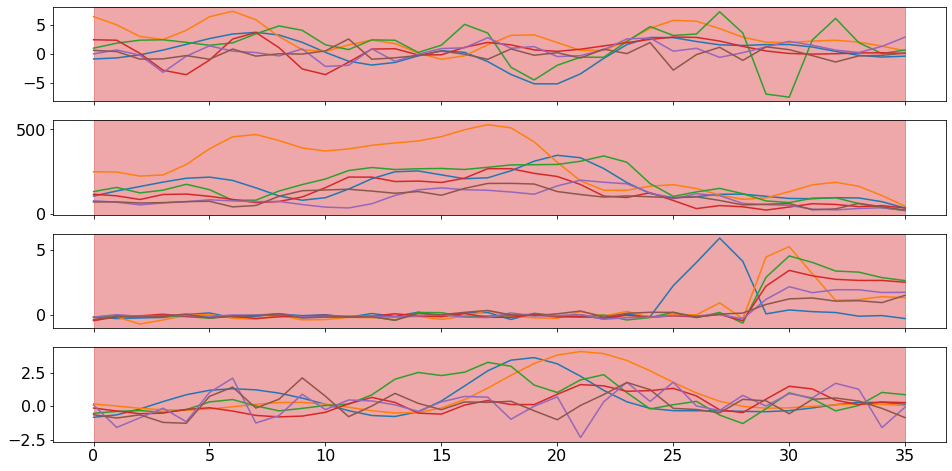

In [50]:
#see the original data
from tsaug.visualization import plot
plot(x_sampled[1:5,:,:], y_sampled_new[1:5,:])

In [51]:
#augmenter...
from tsaug import AddNoise, Dropout, Convolve, Pool, Reverse, Drift

augmenter = (
    AddNoise(scale=0.01)
    + Dropout(p=0.05)
    + Convolve(window="flattop", size=10)
    + Pool(size = 1)
    + Reverse(prob = 0.5)
    + Drift(max_drift = 0.2, n_drift_points=3)
)

#...augment data
x_aug, y_aug = augmenter.augment(x_sampled, y_sampled_new)

In [52]:
#going back to the original shape
y_aug_new = np.reshape(np.unique(y_aug,axis=-1) , newshape = (y_aug.shape[0]))

print('Shapes:')
print(x_aug.shape)
print(y_aug.shape)

Shapes:
(396, 36, 6)
(396, 36)


(<Figure size 1152x576 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

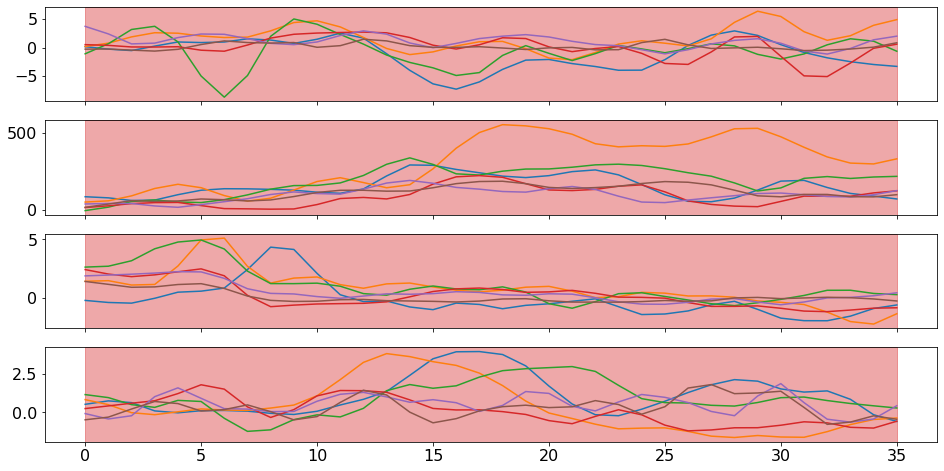

In [53]:
#checking for the augmentation made
from tsaug.visualization import plot
plot(x_aug[1:5:,:,:],y_aug[1:5,:])

In [54]:
#add the augmented data to the training set
x_train_new = np.concatenate((x_train, x_aug))
y_train_new = np.concatenate((y_train, tfk.utils.to_categorical(y_aug_new)))

print('Shapes:')
print(x_train_new.shape)
print(y_train_new.shape)

Shapes:
(2339, 36, 6)
(2339, 12)


Counter({9: 622, 3: 406, 6: 343, 2: 269, 5: 150, 1: 123, 8: 122, 10: 81, 7: 65, 4: 65, 11: 55, 0: 38})


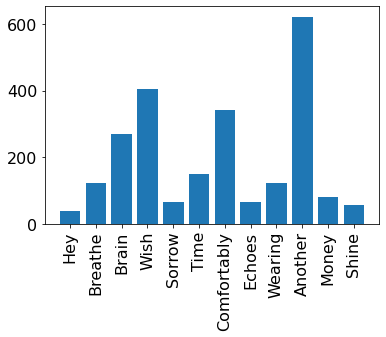

In [55]:
#check the class imbalance after augmenting data
import collections

train_counter = collections.Counter(np.argmax(y_train_new,axis=-1))    
print(train_counter)
#training set
plt.bar(train_counter.keys(), train_counter.values(),tick_label=classes_labels)
plt.xticks(rotation=90)
plt.show()

# DROPPING FEATURES
From the telegram group of the course: it may be useful to drop feature 1

In [56]:
print('Shapes:')
print('x_train: ', x_train.shape)
print('x_val: ', x_val.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)

Shapes:
x_train:  (1943, 36, 6)
x_val:  (486, 36, 6)
y_train:  (1943, 12)
y_val:  (486, 12)


In [57]:
x_train_new = np.delete(x_train,0,axis=2)
x_val_new = np.delete(x_val,0,axis=2)
print("Updated shapes:")
x_train_new.shape, x_val_new.shape

Updated shapes:


((1943, 36, 5), (486, 36, 5))